In [1]:
import sys
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from mpl_settings_v3 import *

from functions import edgelist_to_nn_set
from functions import ID_attack, RD_attack, ICI_attack, RCI_attack, percolate

In [8]:
def attack_network(nn_set, attack):
    if attack == 'ID':
        order = ID_attack(nn_set)
    if attack == 'RD':
        order = RD_attack(nn_set)
    if attack == 'ICI':
        order = ICI_attack(nn_set, l=1)
    if attack == 'RCI':
        order = RCI_attack(nn_set, l=1)
    if attack == 'ICI2':
        order = ICI_attack(nn_set, l=2)
    if attack == 'RCI2':
        order = RCI_attack(nn_set, l=2)
    return order

attacks = ['ID', 'RD', 'ICI', 'ICI2', 'RCI', 'RCI2']
#attacks = ['ID', 'ICI', 'ICI2']
#attacks = ['RD', 'RCI', 'RCI2']

N = 1000000
meank = 3.5
p = meank / N
g = ig.Graph().Erdos_Renyi(N, p)
edgelist = []
for e in g.es():
    edgelist.append(e.tuple)

orders = {}
print('Computing order')
for attack in attacks:
    print(attack)
    nn_set = edgelist_to_nn_set(edgelist)
    order = attack_network(nn_set, attack)[::-1]
    orders[attack] = order
    
N1_values_dict = {}
print('Performing percolation')
for attack in attacks:
    print(attack)
    nn_set = edgelist_to_nn_set(edgelist)
    N1_values = percolate(nn_set, orders[attack])
    N1_values_dict[attack] = N1_values

Computing order
ID
RD
ICI
ICI2
RCI
RCI2
Performing percolation
ID
RD
ICI
ICI2
RCI
RCI2


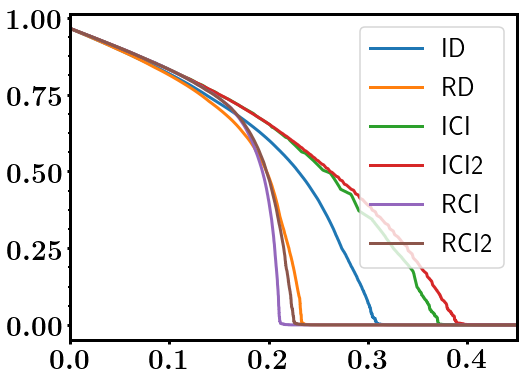

In [9]:
X = (np.arange(N)/N)[::-1]

fig, ax = plt.subplots(figsize=(8, 6))

for attack in attacks:
    ax.plot(X, np.array(N1_values_dict[attack])/N, '-', label=attack)
ax.set_xlim(0, 0.45)
#ax.axvline(0.2116)
#ax.axvline(0.25)

ax.legend()
plt.show()

In [64]:
nn_set = [
            set([3, 4, 5, 6, 7]),
            set([12, 13, 14, 15]),
            set([18, 19, 20]),
            set([0, 8, 9]),
            set([0, 10]),
            set([0, 11]), # 5
            set([0]),
            set([0]),
            set([3, 27]),
            set([3]),
            set([4]), # 10
            set([5]),
            set([1, 16]),
            set([1, 17]),
            set([1, 28]),
            set([1]), # 15
            set([12]),
            set([13]),
            set([2, 21]),
            set([2, 22]),
            set([2, 23]), # 20
            set([18, 24]),
            set([19, 25]),
            set([20, 26]),
            set([21]),
            set([22]), # 25
            set([23]),
            set([8]),
            set([14])
        ]
order = RCI_attack(nn_set, l=2)
print(order)

KeyError: 18

In [63]:
from functions import get_neighbors_ball_border
def update_ci(v, w, nn_set, deg_seq, CI_seq, l):

    kv = deg_seq[v]
    kw = deg_seq[w]
    ci_w = CI_seq[w]

    common_nn = nn_set[v].intersection(nn_set[w])

    if l == 1:
        if w in nn_set[v]: ## Case w nearest neighbor of v
            w_neighbors = nn_set[w].difference(set([v]))

            s = 0
            for w_nn in w_neighbors:
                k_nn = deg_seq[w_nn]
                s += (k_nn - 1)

            new_ci_w = ci_w - (kw-1)*(kv-1) - s - (kw-2)*len(common_nn)

        else: ## Case w not nearest neighbor of v.
            new_ci_w = ci_w - (kw-1)*len(common_nn)
    
    if l == 2:
        second_neighbors = set(get_neighbors_ball_border(nn_set, w, 2))
        common_second_neighbors = nn_set[v].intersection(second_neighbors)
        if w in nn_set[v]:
            
            S1 = nn_set[v].intersection(nn_set[w])
            S2 = set([])
            for u in nn_set[w].difference(S1).difference(set([v])):
                S2 = S2.union(nn_set[u])
            S2 = S2.intersection(nn_set[v]).difference(set([w]))
            S3 = nn_set[v].difference(S1.union(S2).union([w]))
            
            sum1 = 0
            for w_nn in nn_set[w].difference(set([v])):
                k_nn = deg_seq[w_nn]
                sum1 += (k_nn - 1)
            sum2 = 0
            for w_sn in set(get_neighbors_ball_border(nn_set, w, 2)):
                k_sn = deg_seq[w_sn]
                sum2 += (k_sn - 1)

            sum3 = 0
            for r in S3:
                k = deg_seq[r]
                sum3 += (k - 1)

            new_ci_w = ci_w - (kw-1)*(kv-1) - sum1 - sum2 - (kw-2)*(len(S1) + len(S2) + sum3)
        elif w in set(get_neighbors_ball_border(nn_set, v, 2)):
            #print('2 nn', common_second_neighbors)
            new_ci_w = ci_w - (kw-1)*(kv-1) - (kw-1)*(len(common_nn) + len(common_second_neighbors))
        else:
            #print('3 nn')
            new_ci_w = ci_w - (kw-1)*len(common_second_neighbors)

    return new_ci_w  

nn_set = [
    set([1, 2, 3]),
    set([0, 4, 5]),
    set([0, 6, 7]),
    set([0, 8, 9]),
    set([1, 5, 9]),
    set([1, 4, 6]),
    set([2, 5, 7]),
    set([2, 6, 8]),
    set([3, 7, 9]),
    set([3, 4, 8]),
]
deg_seq = [len(s) for s in nn_set]
CI_seq = get_CI(nn_set, l=2)
print(CI_seq)
v = 0
w = 1
new_ci_w = update_ci(v, w, nn_set, deg_seq, CI_seq, l=2)
print(new_ci_w)

w = 4
new_ci_w = update_ci(v, w, nn_set, deg_seq, CI_seq, l=2)
print(new_ci_w)

for r in nn_set[0]:
    nn_set[r].remove(0)
nn_set[0].clear()
CI_seq = get_CI(nn_set, l=2)
CI_seq

[36, 28, 28, 28, 28, 28, 28, 28, 28, 28]
8
20


[0, 8, 8, 8, 20, 20, 20, 20, 20, 20]